Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

##### Explicacion de un skip-gram: [Word2Vec-skipgram](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
consiste en crear un "concepto" de cada palabra basado en la relación con las demás palabras del vocabulario, y luego poder usar ese concepto posteriormente, dado que tratamos con un sistema no supervisado

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [4]:
import math
import time
def how_long(f, *args):
    #medir el tiempo que tarda f
    t1 = time.time()
    res = f(*args)
    t2 = time.time()
    print ("tiempo utilizado = ",t2-t1)
    #return res, t2-t1
    return res

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def build_dataset(words):
  #inicializa el array de contadores de palabras (frecuencias)
  count = [['UNK', -1]]
  #cuenta las 50000 palabras más comunes
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  #inicializa un diccionario del vocabulario, va a crear pares palabra - ID, para tratar con números
  #y asigna los id por orden de frecuencia de más a menos
  #RESERVA ID=0 para los "OTROS POCO FRECUENTES" que llama "UNK"
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  #inicializa y crea una lista de ID equivalente al dataset "words" reemplazando cada palabra por su ID
  #y de paso va apuntando los UNK para rellenar la frecuencia
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  #apunta el dato final de cuantas palabras raras hay (frecuencia de palabras raras)
  count[0][1] = unk_count
  #crea un diccionario al revés, es decir, donde el ID es la clave y la palabra es el valor
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = how_long(build_dataset,words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

tiempo utilizado =  35.0641279221
Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

#batch_size, tamaño del lote a meter en la red neural para aprender
#skip_window, tamaño del lado derecho e izquierdo de la ventana alrededor de una palabra (es simétrica)
#num_skips, distancia de palabra adyacente que va a tomar como etiqueta 

def generate_batch_skipgram(batch_size, num_skips, skip_window):
  global data_index #indicador de por donde va recorriendo los datos de aprendizaje
  
  #comprobaciones
  assert batch_size % num_skips == 0 #el tamaño del lote debe ser divisible por los descartes
  assert num_skips <= 2 * skip_window

  #variables a usar
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ] 
    #se mira alrededor de la palabra el ancho de ventana (2*ventana y +1 la palabra en medio)
  buffer = collections.deque(maxlen=span) #reserva variable vacía tipo "deque" para almacenar 
                                            #una ventana que rodea una palabra
  
  #rellena una ventana inicial desde donde se quedo
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data) #circular

  #rellena un lote y a cada palabra le pone de objetivo las palabras adyacentes a distancia 
    #num_skips o menor delante y detrás
  #siempre por pares, pero tomando RANDOM de esa ventana, no en orden
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      #monta todo este lío para que no vayan en orden exacto las palabras...
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    
    #pasa a la siguiente ventana
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  return batch, labels

#Ejecucion de ejemplo para las primeras ocho palabras del diccionario (un lote de ocho)

lote = 8
print('data:', [reverse_dictionary[di] for di in data[:lote]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch_skipgram(batch_size=lote, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(lote)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'anarchism', 'a', 'originated', 'originated', 'as', 'of', 'term']


Train a skip-gram model.

In [7]:
##################
# DECLARACION SKIP-GRAM
##################

batch_size = 128 #Lotes de entrenamiento.

embedding_size = 128 # Dimension of the embedding vector. Las features de cada palabra que la distinguen.
skip_window = 1 # How many words to consider left and right. Semiventana, al final ventana de 3.
                # Es poco debería ser mayor pero más procesamiento también.
num_skips = 2 # How many times to reuse an input to generate a label. 
                #Normalmente ancho-ventana - 1 (3-1 = 2). O 2*skip_window

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by construction are also the most frequent. 
# Va a utilizar como validationSet las palabras más comunes del diccionario (las del principio)
valid_size = 16 # Random set of words to evaluate similarity on. Escoge 16 para validacion.
valid_window = 100 # Only pick dev samples in the head of the distribution. Las escoge de entre las 100 primeras.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

# CURIOSAMENTE NO TOMA UN TEST SET ESTA VEZ, LE DA IGUAL

num_sampled = 64 # Number of negative examples to sample. Muestras aleatorias de entre el lote 
                                                        #que sirven para calcular LOSS.

learning_rate = 1.0

graphSG = tf.Graph()

with graphSG.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables y su inicializacion.
       #CONCEPTO-FEATURES DE UNA PALABRA (primer layer):
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) 
      #RELACION CON OTROS CONCEPTOS (segundo layer):
  softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset) #Toma de los conceptos las líneas que corresponden 
                                                            #al lote de turno (por ID)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed, train_labels, num_sampled, vocabulary_size)) 
        #Combina cada conceptos con las relaciones y obtiene la probabilidad de vecindad de las demás palabras del diccionario
        #luego compara esa vecindad probable con las etiquetas para num_sampled aleatorias y saca la pérdida

  #At inference time, you can compute full softmax probabilities for each word (referred to one word) with the expression 
  #tf.nn.softmax(tf.matmul(one_embed, tf.transpose(softmax_weights)) + softmax_biases).
        
  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

###### OJO Usa un optimizador de gradiente adaptativo:
[Adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

In [8]:
##################
# EJECUCION SKIP-GRAM
##################

num_steps = 100001
loss_report_interval = 2000
similarity_report_interval = 10000
top_k = 8 # number of nearest neighbors a mostrar en el informe de similitud

t1 = time.time()

with tf.Session(graph=graphSG) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0

  # iterar
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_skipgram(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, L = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += L

    # mostar la perdida media de un intervalo
    if step % loss_report_interval == 0:
      t2 = time.time()
      if step > 0:
        average_loss = average_loss / loss_report_interval
      # The average loss is an estimate of the loss over the last loss_report_interval batches.
      print('step %d\t%ds\tAverage loss: %f' % (step,t2-t1, average_loss))
      average_loss = 0
    
    # mostrar la similitud alcanzada en un intervalo
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % similarity_report_interval == 0:
      sim = similarity.eval() #tomar la variable calculada de similitud
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        nearest = (-sim[i, :]).argsort()[1:top_k+1] # del vector de probabilidades de vecindad toma los 8 mayores
        log = '\tNearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
        
  #final_n = norm.eval() #tomar el denominador de normalizacion a ver si tiene ceros
  final_skipgram_embeddings = normalized_embeddings.eval() 
    #me quedo con las features finales que definen cada concepto de palabra
  print('End.')

Initialized
step 0	1s	Average loss: 8.236175
	Nearest to zero: allele, nicolay, crucial, dharmas, illusion, locator, speaker, iconostasis,
	Nearest to will: tac, dubbing, cowan, weights, identifier, peacocks, olivia, shipwrecked,
	Nearest to so: booths, modalities, lasker, nikolaevich, bolshevism, flasks, fell, austere,
	Nearest to can: donuts, eratosthenes, carnal, advisors, hypocrites, damage, byrd, mario,
	Nearest to are: words, goa, kinship, unplugged, erwin, rotation, chorus, proven,
	Nearest to would: spitfire, morphemes, legionaries, suzuki, imr, urgency, anchorages, accelerating,
	Nearest to time: presses, monotheist, exhortation, mtp, huey, abdicates, anjou, horseshoe,
	Nearest to no: sars, cadillac, mod, leonhard, heiress, processing, spared, chilperic,
	Nearest to people: nitrous, proverbs, cycling, emet, hyphens, dickie, celtiberian, honestly,
	Nearest to united: amplifier, directx, objectively, beaten, geer, park, hummers, tanakh,
	Nearest to in: pedestrians, copperfield, 

###### Vamos a dibujar usando herramienta de TensorFlow: 
[TNSE] (https://www.tensorflow.org/tutorials/word2vec/?authuser=2)


In [9]:
#Me da error de que final_embeddings tiene un Nan o un Inf y no es así
#kk = final_n.reshape(vocabulary_size)
#print(np.isnan(kk).any())
#print(np.isinf(kk).any())
print(final_skipgram_embeddings.shape)
kk = final_skipgram_embeddings.reshape(vocabulary_size*embedding_size)
print(kk)
print(np.isnan(kk).any())
print(np.isinf(kk).any())

(50000, 128)
[-0.01716124 -0.20696527 -0.11946616 ..., -0.14512001  0.04967998
  0.01002654]
False
False


Es un fallo de numpy o de sci-kit:
    (https://github.com/amygdala/tensorflow-workshop/issues/12)
TAMBIEN SE AREGLA USANDO MAS MUESTRAS PARA DIBUJAR, PERO LUEGO HAY QUE TOMAR UN SUBRANGO O EL GRAFICO QUEDA COMO UNA CACA, VAYA TELA

In [10]:
#num_points = 400
num_points = 3000 #por el bug
tsneSG = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsneSG.fit_transform(final_skipgram_embeddings[1:num_points+1, :])

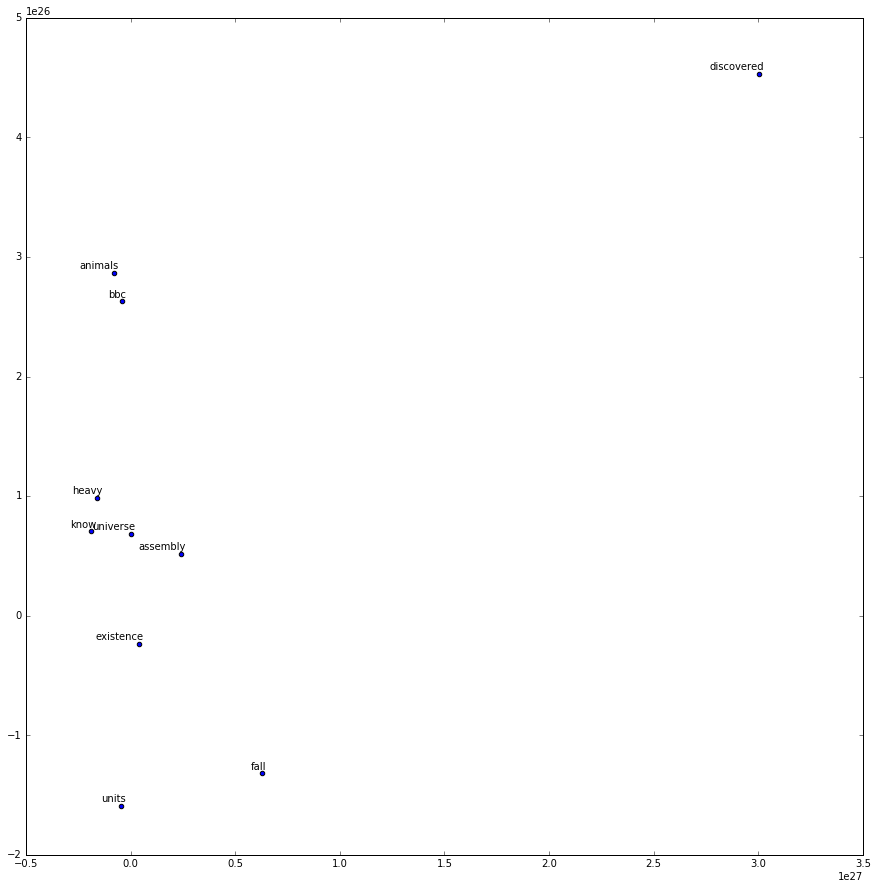

In [11]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()


#Vamos a dibujar un rango

#plot_desde = 1
plot_desde = 1000 #debe ser mayor o igual que 1
#num_plot = 400
num_plot = 10

assert (plot_desde > 1), 'solo se puede pintar del 1 en adelante'
assert (plot_desde+num_plot <= num_points), 'no se puede pintar más de lo calculado'

words = [reverse_dictionary[i] for i in range(plot_desde, plot_desde+num_plot)]
embeddings_subset = two_d_embeddings[plot_desde:plot_desde+num_plot, :]
plot(embeddings_subset, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

###### NOTA: me apoyo en su generate_batch de base pero quizás debería hacerme el mío que en lugar de poner como objetivo la palabra de en medio ponga la del final de cada ventana (aunque en su artículo dicen que quieren buscar el de enmedio)

In [41]:
data_index = 0

#batch_size, tamaño del lote a meter en la red neural para aprender
#skip_window, tamaño del lado derecho e izquierdo de la ventana alrededor de una palabra (es simétrica)
#num_skips, distancia de palabra adyacente que va a tomar como etiqueta  (2 x skip_window)

def generate_batch_cbow(batch_size, num_skips, skip_window):
    ids, lids = generate_batch_skipgram(num_skips*batch_size, num_skips, skip_window)
    batch = lids.reshape(batch_size,num_skips)
    labels = ids[np.arange(0,num_skips*batch_size,num_skips)].reshape(batch_size,1)

    return batch, labels
    
#Ejecucion de ejemplo para las primeras ocho palabras del diccionario (un lote de ocho)

lote = 8
print('data:', [reverse_dictionary[di] for di in data[:2*lote]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))

    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=lote, num_skips=num_skips, skip_window=skip_window)
    
    def show2D(a):
        for L in a:
            print([reverse_dictionary[i] for i in L])
    
    print('    IDs:')
    show2D(batch)
    print('    IDlabels:', [reverse_dictionary[li] for li in labels.reshape(lote)])   


data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with num_skips = 2 and skip_window = 1:
    IDs:
['as', 'anarchism']
['a', 'originated']
['as', 'term']
['of', 'a']
['abuse', 'term']
['of', 'first']
['abuse', 'used']
['against', 'first']
    IDlabels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
    IDs:
['a', 'term', 'anarchism', 'originated']
['as', 'originated', 'term', 'of']
['as', 'of', 'a', 'abuse']
['abuse', 'a', 'first', 'term']
['used', 'first', 'term', 'of']
['abuse', 'of', 'against', 'used']
['early', 'against', 'abuse', 'first']
['used', 'working', 'early', 'first']
    IDlabels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [42]:
##################
# DECLARACION CBOW
##################

batch_size = 128 #Lotes de entrenamiento.

embedding_size = 128 # Dimension of the embedding vector. Las features de cada palabra que la distinguen.
skip_window = 1 # How many words to consider left and right. Semiventana, al final ventana de 3.
                # Es poco debería ser mayor pero más procesamiento también.
num_skips = 2 # How many times to reuse an input to generate a label. 
                #Normalmente ancho-ventana - 1 (3-1 = 2). O 2*skip_window

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by construction are also the most frequent. 
# Va a utilizar como validationSet las palabras más comunes del diccionario (las del principio)
valid_size = 16 # Random set of words to evaluate similarity on. Escoge 16 para validacion.
valid_window = 100 # Only pick dev samples in the head of the distribution. Las escoge de entre las 100 primeras.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

num_sampled = 64 # Number of negative examples to sample. Muestras aleatorias de entre el lote que sirven para calcular LOSS.

learning_rate = 1.0

graphCB = tf.Graph()

with graphCB.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables y su inicializacion.
      #RELACION CON OTROS CONCEPTOS (primer layer):
  softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
       #CONCEPTO-FEATURES DE UNA PALABRA (segundo layer):
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) 
    
  # Model.
  # Look up embeddings for outputs.
  embed = tf.zeros([batch_size, embedding_size])
  for j in range(num_skips): #El embedding objetivo es la suma de los embeddings de la bolsa de palabras correspondiente
        embed += tf.nn.embedding_lookup(embeddings, train_dataset[:, j])

  # Compute the softmax loss, using a sample of the negative train data each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed, train_labels, num_sampled, vocabulary_size)) 
        
  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [43]:
##################
# EJECUCION CBOW
##################

num_steps = 100001
loss_report_interval = 2000
similarity_report_interval = 10000
top_k = 8 # number of nearest neighbors a mostrar en el informe de similitud

t1 = time.time()

sessCB = tf.Session(graph=graphCB)
with sessCB as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0

  # iterar
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, L = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += L

    # mostar la perdida media de un intervalo
    if step % loss_report_interval == 0:
      t2 = time.time()
      if step > 0:
        average_loss = average_loss / loss_report_interval
      # The average loss is an estimate of the loss over the last loss_report_interval batches.
      print('step %d\t%ds\tAverage loss: %f' % (step,t2-t1, average_loss))
      average_loss = 0
    
    # mostrar la similitud alcanzada en un intervalo
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % similarity_report_interval == 0:
      sim = similarity.eval() #tomar la variable calculada de similitud
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        nearest = (-sim[i, :]).argsort()[1:top_k+1] # del vector de probabilidades de vecindad toma los 8 mayores
        log = '\tNearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
        
  final_cbow_embeddings = normalized_embeddings.eval() 
        #me quedo con las features finales que definen cada concepto de palabra
  print("End.")

Initialized
step 0	0s	Average loss: 8.415958
	Nearest to when: farewell, vices, allegories, satie, retrieve, hatcher, pacino, fawlty,
	Nearest to a: livingston, xxvii, pencils, parnassus, halfwidth, amraam, balloons, humble,
	Nearest to first: bragi, dmitry, brigid, traditionalists, enumerated, underwent, cues, indulgences,
	Nearest to time: shtml, hogeschool, loudspeakers, rterbuch, newell, lio, czechoslovakian, bowman,
	Nearest to american: sag, archimedes, methylene, hutchison, boles, recumbent, secrecy, achievable,
	Nearest to about: actions, abm, hale, terrence, data, asphyxia, airline, inscriptions,
	Nearest to more: balked, assumptions, overwrite, comiskey, ruskin, voss, wuhan, simplex,
	Nearest to its: arin, asw, complexes, pasta, enigma, nitroglycerin, juneau, ex,
	Nearest to from: biographers, cesium, proportionate, nucleotide, forcefully, bridged, orwell, erasure,
	Nearest to many: depths, hairpin, humorist, longest, kov, subconscious, taps, bo,
	Nearest to by: judges, presb

##### Vamos a dibujar cosas

In [44]:
#Nearest to be: been, being, become, have, refer, is, ratifies, were,
"""
word = 'be'
word_id = data[dictionary[word]]

with graphCB.as_default(), tf.device('/cpu:0'):
      norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
      normalized_embeddings = embeddings / norm
      myembedding = tf.nn.embedding_lookup(normalized_embeddings, [word_id])
      OneSimilarity = tf.matmul(myembedding, tf.transpose(normalized_embeddings))
    
with sessCB as session:
      n = norm.eval()
      print(n.shape)
      e = myembedding.eval()
      print(e.shape)
      sim = OneSimilarity.eval()
      print(sim.shape)
      nearest = (-sim[0, :]).argsort()[1:top_k+1] # del vector de probabilidades de vecindad toma los 8 mayores
      log = '\tNearest to %s:' % word
      for k in range(top_k):
        close_word = reverse_dictionary[nearest[k]]
        log = '%s %s,' % (log, close_word)
      print(log)    
"""

"\nword = 'be'\nword_id = data[dictionary[word]]\n\nwith graphCB.as_default(), tf.device('/cpu:0'):\n      norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))\n      normalized_embeddings = embeddings / norm\n      myembedding = tf.nn.embedding_lookup(normalized_embeddings, [word_id])\n      OneSimilarity = tf.matmul(myembedding, tf.transpose(normalized_embeddings))\n    \nwith sessCB as session:\n      n = norm.eval()\n      print(n.shape)\n      e = myembedding.eval()\n      print(e.shape)\n      sim = OneSimilarity.eval()\n      print(sim.shape)\n      nearest = (-sim[0, :]).argsort()[1:top_k+1] # del vector de probabilidades de vecindad toma los 8 mayores\n      log = '\tNearest to %s:' % word\n      for k in range(top_k):\n        close_word = reverse_dictionary[nearest[k]]\n        log = '%s %s,' % (log, close_word)\n      print(log)    \n"

In [45]:
def show_nearest_embeddings_PCA(word,norm_embeddings,area=10):
    
    assert (word in dictionary), 'This word is not in the dictionary'
    
    word_id = dictionary[word]
    print('ID for "' + word +'" is ' + str(word_id))

    # Compute the similarity between selected word and all embeddings.
    print('computing neighbors...')

    # We use the cosine distance:
    my_embedding = norm_embeddings[word_id]
    S = np.matmul(my_embedding, np.transpose(norm_embeddings))
    #np.reshape(tensor=similarity,shape=[vocabulary_size])  

    words = []
    nearest = (-S).argsort()[1:area+1] # del vector de probabilidades de vecindad toma los mayores MENOS ÉL MISMO
    log = '\tNearest %d to "%s":' % (area,word)
    for k in range(area):
        close_word = reverse_dictionary[nearest[k]]
        words = words + [close_word]
        log = '%s %s,' % (log, close_word)
    print(log)
    
    #Incluyo la propia palabra para que se vea tambien en el dibujo
    words = words + [word]
    nearest = np.append(nearest,word_id)
    #print(nearest)
    #print(words)

    #Funcion para pintar las proyecciones 2D
    def plot2D(embeddings, labels):
      assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
      pylab.figure(figsize=(15,15))  # in inches
      for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',ha='right', va='bottom')
      pylab.show()

    print('projecting and plotting...')

    #embeddings_subset = norm_embeddings[1:301, :] # da BUG
    #embeddings_subset = norm_embeddings[initial_word:num_points+1, :]
    #embeddings_subset = norm_embeddings #si calculo todos REVIENTA el ordenador el TSNE
    embeddings_subset = norm_embeddings[nearest, :] #si calculo demasiado pocos REVIENTA también TSNE :-(
    
    #Calcular el TSNE (NO PORQUE FALLA)
    #px = 30
    #px = area
    #tsne = TSNE(perplexity=px, n_components=2, init='pca', n_iter=5000)
    #two_d_embeddings_tsne = tsne.fit_transform(embeddings_subset)
    
    #aplico PCA porque si funciona
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    two_d_embeddings_pca = pca.fit_transform(embeddings_subset)
    print("\tPCA variance ratio",pca.explained_variance_ratio_)
    
    #Vamos a dibujar un rango de número de elementos "area" alrededor de la palabra
    plot2D(two_d_embeddings_pca, words)    

(50000, 128)
ID for "some" is 48
computing neighbors...
	Nearest 8 to "some": many, several, these, any, various, those, all, numerous,
projecting and plotting...
	PCA variance ratio [ 0.2471493   0.18742071]


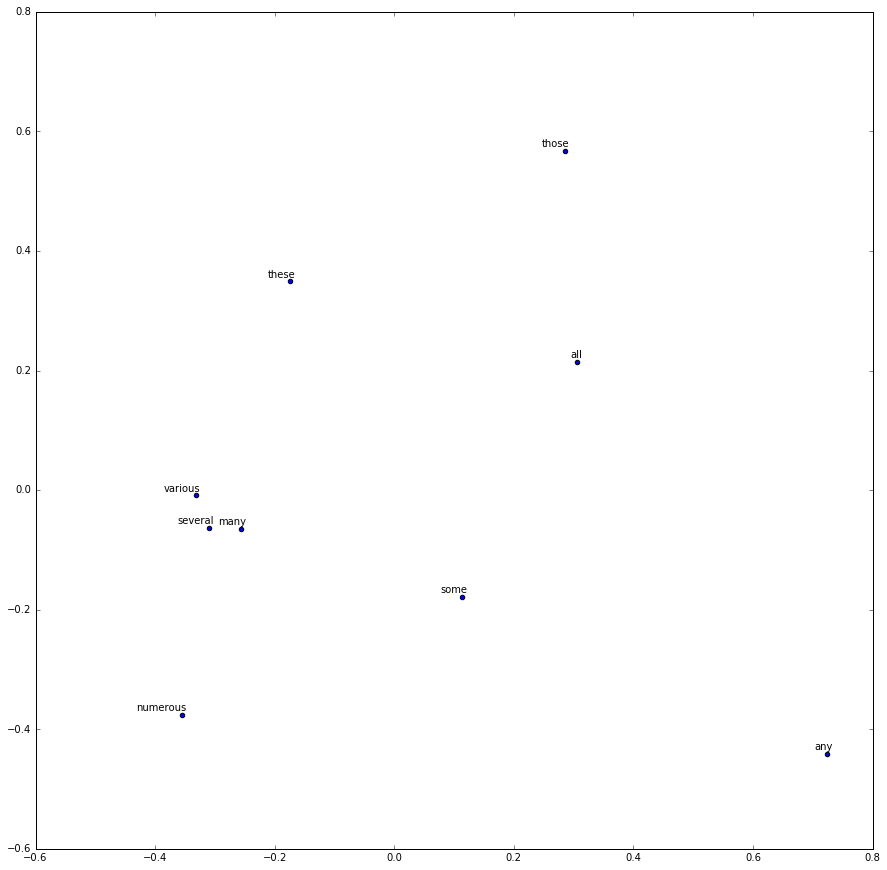

In [48]:
#SKIPGRAM
#Nearest to some: many, several, these, any, various, those, all, numerous,
print(final_skipgram_embeddings.shape)
show_nearest_embeddings_PCA('some',final_skipgram_embeddings,area=8)

ID for "some" is 48
computing neighbors...
	Nearest 8 to "some": many, several, any, certain, these, most, this, various,
projecting and plotting...
	PCA variance ratio [ 0.22890547  0.19436271]


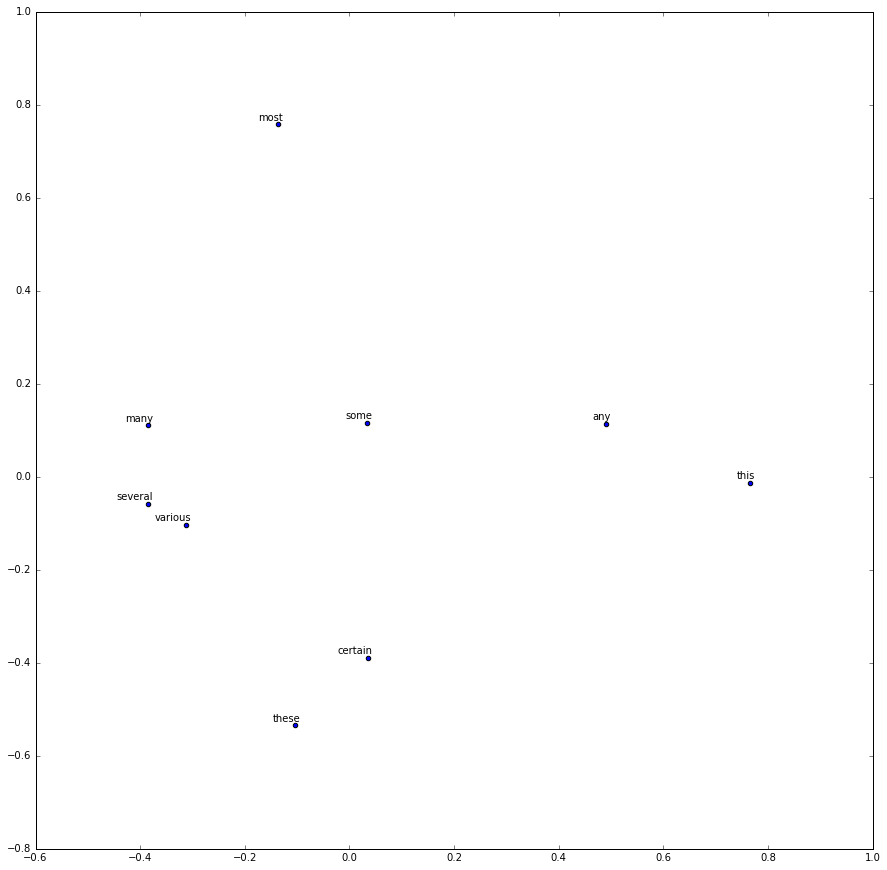

In [49]:
#CBOW
#Nearest to some: many, several, any, certain, these, most, this, various,
print(final_cbow_embeddings.shape)
show_nearest_embeddings_PCA('some',final_cbow_embeddings,area=8)